In [21]:
import pandas as pd
import tiktoken
import os
import openai
from ast import literal_eval
import numpy as np

emb_path = 'css_topic_embeddings.csv'

In [3]:
# Load environment variables from the .env file
from dotenv import load_dotenv
load_dotenv()

# Verify that the environment variable is set
openai.api_key = os.environ["OPENAI_API_KEY"]

In [ ]:
# https://cookbook.openai.com/examples/get_embeddings_from_dataset
from utils.embeddings_utils import get_embedding
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [7]:
# load & inspect dataset
input_datapath = "css.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath)
print(df.columns)

Index(['Type', 'Speaker', 'Topic', 'Year'], dtype='object')


In [ ]:
df = df[["Type","Speaker","Topic","Year"]]
df = df.dropna()
df["combined"] = (
    "Type: " + df.Type.str.strip() + "; Speaker: " + df.Speaker.str.strip() + "; Topic: " + df.Topic.str.strip() + "; Year: " + df.Year.str.strip()
)

df.head(2)

,Type,Speaker,Topic,Year,combined
0,Keynote,Michael Macy,Opportunities and challenges for computational...,2015,Type: Keynote; Speaker: Michael Macy; Topic: O...
1,Keynote,Jure Leskovec,Structure and dynamics of information propagation,2015,Type: Keynote; Speaker: Jure Leskovec; Topic: ...


In [13]:
encoding = tiktoken.get_encoding(embedding_encoding)

In [18]:
# Ensure you have your API key set in your environment per the README: https://github.com/openai/openai-python#usage

# This may take a few minutes
df["embedding"] = df.Topic.apply(lambda x: get_embedding(x, model=embedding_model))
df.to_csv("css_topic_embeddings.csv")

In [22]:
df = pd.read_csv(emb_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape

(2747, 1536)

In [30]:
from sklearn.cluster import KMeans

n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels
df.columns

Index(['Unnamed: 0', 'Type', 'Speaker', 'Topic', 'Year', 'combined',
       'embedding', 'Cluster'],
      dtype='object')

In [ ]:

df.groupby("Cluster").Topic.mean().sort_values()


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

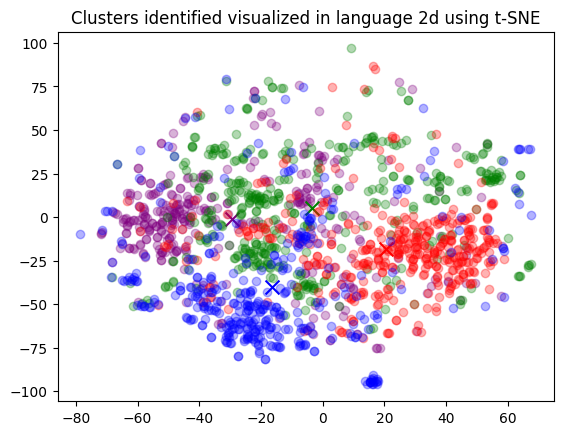

In [31]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")
